In [1]:
# Author: Renzo Caballero, Ph.D.
# Email: renzo.caballero@weblab.t.u-tokyo.ac.jp, caballeroren@gmail.com
# Date: Jenuary, 2025

import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cProfile
import sys

In [2]:
m0 = 1;
m = 3;
n0 = 1;
n = 3;

energy_tol = 0.01;
very_large_cost = 10000; # This is used to the system never goes in that direction.

T = 1;
A = 1;

k1 = 1;
k2 = 1;

K = 1; # Power constant.

tau = 1/4; # WARNING: tau is dimensionless in this code.

num_delta_T = 2 ** (m0 + m);
num_delta_phi = 2 ** (n0 + n);
num_delta_h1 = 2 ** (n0+m0+n+m);
num_delta_h2 = num_delta_h1 * (1 + (1-tau));

tau_int = int(tau*num_delta_T);
T_minus_tau_int = num_delta_T - tau_int;

phi_max = 1;
v1_max = phi_max * T;
v1_min = 0;
v2_max = phi_max * T * (1+(1-tau));
v2_min = 0;

delta_phi = phi_max / num_delta_phi;
delta_T = T / num_delta_T;

h1_ini = phi_max * T / A;
h2_ini = phi_max * T / A;

h1_max = phi_max * T / A;
h2_max = phi_max * T * (1 + (1-tau)) / A;

dual_var = np.zeros(int(num_delta_T)); # Lambda.
D        = np.ones(int(num_delta_T)); # Lambda.

def running_cost(i,step1,step2,step_tau,h1,h2,D):

    P1 = (h1/num_delta_h1)*K*(step1/num_delta_phi);
    P2 = (h2/num_delta_h1)*K*(step2/num_delta_phi);
    if abs(D-P1-P2)/D > 0.01:
        return(float('inf'));
    else:
        cost = 0;
        if i >= T_minus_tau_int:
            cost = cost - (step1/num_delta_phi)*k2
        if i >= tau_int:
            cost = cost + dual_var[i]*(step_tau/num_delta_phi);
        if i < T_minus_tau_int:
            cost = cost - dual_var[i+tau_int]*(step1/num_delta_phi)
        return cost

def outer_sum(aux_1, aux_2):
    return aux_1[:, np.newaxis] + aux_2[np.newaxis, :];

print('Number of space-time points:',7*2**(3*m0+3*m+2*n0+2*n-2));
print('Number of admissible space-time points ~',int(7*2**(3*m0+3*m+2*n0+2*n-2)/3));
print('Number of running-cost calculations ~',int(7*2**(3*m0+3*m+5*n0+5*n-2)/3));

Number of space-time points: 1835008
Number of admissible space-time points ~ 611669
Number of running-cost calculations ~ 2505397589


#h1 =  256
#h2 =  448
#T =  16
Plotting...


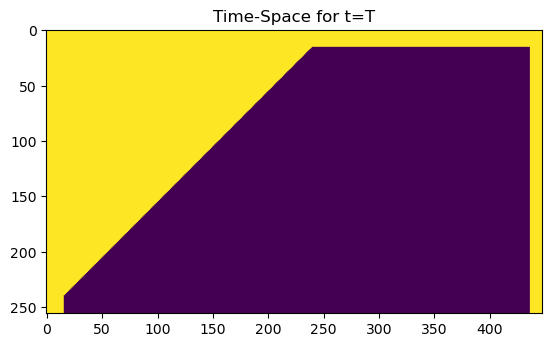

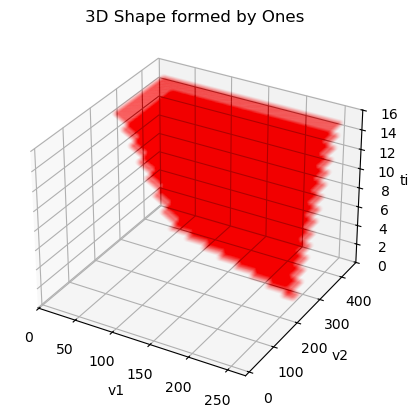

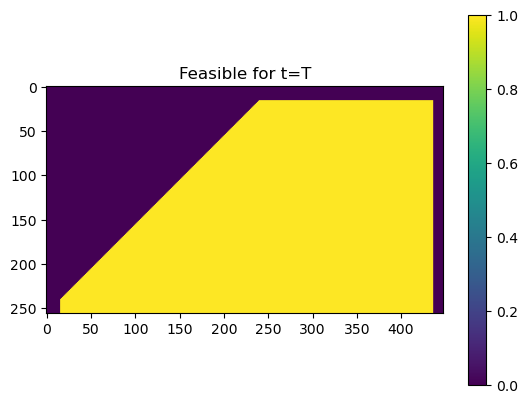

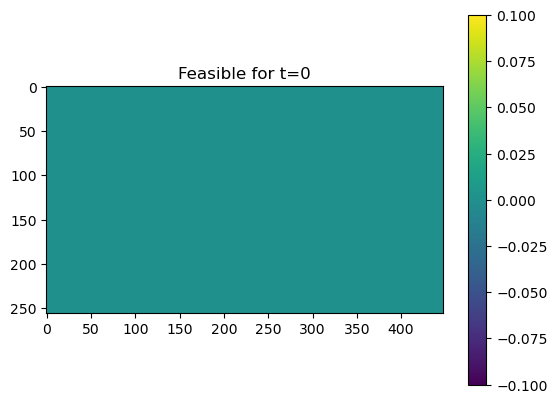

In [3]:
print('#h1 = ', int(num_delta_h1));
print('#h2 = ', int(num_delta_h2));
print('#T = ',  int(num_delta_T));

valueFunction   = np.zeros((int(num_delta_h1), int(num_delta_h2), int(num_delta_T))); # v1, v2, time.
optimalControls = np.ones((int(num_delta_h1), int(num_delta_h2), int(num_delta_T), 3)); # v1, v2, time (R3-->R3).
feasibleSpace   = np.ones((int(num_delta_h1), int(num_delta_h2), int(num_delta_T))); # v1, v2, time.

# Final value:
for i in range(0,int(num_delta_h1)):
    for j in range(0,int(num_delta_h2)):
        prop_1 = i / num_delta_h1;
        prop_2 = j / num_delta_h1;
        valueFunction[i,j,-1] = - prop_1 * v1_max * k1 - prop_2 * v2_max * k2;

# Admissible set:
# In theory, some time-states are impossible to reach due to the dynamics of the system.
# There are points that cannot be reached due to the initial state and the extreme flow.
# Additionally, there are states that can be reached, but they cannot supply the needed power.
# Here, we block for of them, but since some of them are technically reachable, we will make their future cost infinite, so DP nieces choose them.
for i in range(0,int(num_delta_h1)):
    for j in range(0,int(num_delta_h2)):
        for k in range(0,int(num_delta_T)):            
            t = k / int(num_delta_T) * T;
            v1 = i / int(num_delta_h1) * v1_max;
            v2 = j / int(num_delta_h2) * v2_max;
            if v1 < phi_max * (T-t) or v1 > phi_max * T or v2 < phi_max * (T-t) or v2 > phi_max * (T + (1-tau) * t):
                feasibleSpace[i,j,k] = 0;
                valueFunction[i,j,k] = very_large_cost;
            if K*(phi_max*i/num_delta_h1 + phi_max*j/num_delta_h1) < D[k]:
                feasibleSpace[i,j,k] = 0;
                valueFunction[i,j,k] = very_large_cost;
            
if 1 == 1:

    print('Plotting...');
    
    last_slice = valueFunction[:, :, -1];
    plt.imshow(last_slice);
    plt.title("Time-Space for t=T");
    plt.show();
    
    x, y, z = np.where(feasibleSpace == 1);
    fig = plt.figure();
    ax = fig.add_subplot(111, projection='3d');
    ax.scatter(x, y, z, c='r', marker='o', alpha=0.005, edgecolors='none');
    ax.set_xlabel('v1');
    ax.set_ylabel('v2');
    ax.set_zlabel('time');
    ax.set_title("3D Shape formed by Ones");
    plt.show();

    aux = feasibleSpace[:, :, -1];
    plt.imshow(aux);
    plt.colorbar();
    plt.title("Feasible for t=T");
    plt.show();
    
    aux = feasibleSpace[:, :, 0];
    plt.imshow(aux);
    plt.colorbar();
    plt.title("Feasible for t=0");
    plt.show();

In [4]:
phi_1 = np.arange(0,num_delta_phi+1)/num_delta_phi;
phi_2 = np.arange(0,num_delta_phi+1)/num_delta_phi;

for k in range(int(num_delta_T)-2,0-1,-1):
# If num_delta_T = 16, the previous loop should go from 14 to 0. Remember, the time vector ranges from 0 to 15, but we want to start from 14.
    for i in range(0,int(num_delta_h1)-1):
        print(i);
        aux_1 = phi_1 * i / num_delta_h1;
        for j in range(0,int(num_delta_h2)-1):

            if feasibleSpace[i,j,k] == 1:

                # i and j divided by num_delta_h1 do from 0-1 and 0-1.75, respectively.
                aux_2 = phi_2 * j / num_delta_h1;
                
                power_matrix = K*outer_sum(aux_1, aux_2);

                if power_matrix[-1,-1] < D[k]:
                    print('No enough Power!');

                addmisible_matrix = abs(D[k]-power_matrix)/D[k];
                addmisible_matrix = addmisible_matrix <= energy_tol;
                addmisible_matrix = addmisible_matrix.astype(float)
                addmisible_matrix[addmisible_matrix == 0] = np.nan;

                if k < tau_int:
                    aux_3 = phi_1 * (-dual_var[k+tau_int]);
                    running_cost_matrix = np.tile(aux_3, (num_delta_phi+1, 1)).T;
                    running_and_future_cost = running_cost_matrix + valueFunction[i:i+num_delta_phi+1,j:j+num_delta_phi+1,k+1];
                elif k >= tau_int and k < T_minus_tau_int:
                    aux_3 = phi_1 * (-dual_var[k+tau_int]);
                    running_cost_matrix = np.tile(aux_3, (num_delta_phi+1, 1)).T;
                    running_and_future_cost = running_cost_matrix + valueFunction[i:i+num_delta_phi+1,j:j+num_delta_phi+1,k+1];
                    if dual_var[k] < 0:
                        running_and_future_cost = running_and_future_cost + dual_var[k]*phi_max;
                elif k >= T_minus_tau_int  and k < num_delta_T:
                    aux_3 = phi_1 * (-k2);
                    running_cost_matrix = np.tile(aux_3, (num_delta_phi+1, 1)).T;
                    running_and_future_cost = running_cost_matrix + valueFunction[i:i+num_delta_phi+1,j:j+num_delta_phi+1,k+1];
                    if dual_var[k] < 0:
                        running_and_future_cost = running_and_future_cost + dual_var[k]*phi_max;
                else:
                    raise ValueError("Error in time variable k!");
                
                #sys.exit();

                cost_matrix = np.zeros((int(num_delta_phi), int(num_delta_phi)));
                for p in range(0,int(num_delta_phi)):
                    for q in range(0,int(num_delta_phi)):
                        for r in range(0,int(num_delta_phi)):
                            cost_matrix[p,q]       = running_cost(k,p,q,r,i,j,1);
                            optimalControls[p,q,k] = [p,q,r];

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240


ValueError: operands could not be broadcast together with shapes (17,17) (16,17) 

In [ ]:
valueFunction[i:i+num_delta_phi+1,j:j+num_delta_phi+1,k+1].shape
print(valueFunction.shape)
print(int(num_delta_h1)-1)
print(i)
print(int(num_delta_h2)-1)
print(j)
print(k)
print(i+num_delta_phi+1)

In [ ]:
cProfile.run("""
#for k in range(int(num_delta_T)-2,int(num_delta_T)-1):
for k in range(int(num_delta_T)-1,0,-1):
    for i in range(0,int(num_delta_h1)-1):

        print(i);
        
        for j in range(0,int(num_delta_h2)-1):

            if feasibleSpace[i,j,k] == 1:

                cost_matrix = np.zeros((int(num_delta_phi), int(num_delta_phi)));
                for p in range(0,int(num_delta_phi)):
                    for q in range(0,int(num_delta_phi)):
                        for r in range(0,int(num_delta_phi)):
                            cost_matrix[p,q]       = running_cost(k,p,q,r,i,j,1);
                            optimalControls[p,q,k] = [p,q,r];
""")

In [ ]:
power_matrix

plt.imshow(power_matrix, cmap='viridis', origin='lower')  # 'viridis' is a good colormap
plt.colorbar(label="Value")  # Add a color legend
plt.title("Matrix Color Field")
plt.xlabel("phi_2 index")
plt.ylabel("phi_1 index")
plt.show()

plt.imshow(addmisible_matrix, cmap='viridis', origin='lower')  # 'viridis' is a good colormap
plt.colorbar(label="Value")  # Add a color legend
plt.title("Matrix Color Field")
plt.xlabel("phi_2 index")
plt.ylabel("phi_1 index")
plt.show()

In [ ]:
m0 = 1;
m = 3;
n0 = 1;
n = 3;
4050376892 function calls in 5166.824 seconds

In [ ]:
addmisible_matrix


In [ ]:
aux_1

In [ ]:
aux_2

In [ ]:
phi_2

In [ ]:
1*np.nan

In [ ]:
num_delta_h1

In [ ]:
raise ValueError("This is an error message to stop execution.")


In [ ]:
addmisible_matrix[addmisible_matrix == True] = int(1);
addmisible_matrix[addmisible_matrix == False] = np.nan;

In [ ]:
addmisible_matrix[addmisible_matrix] = 1  # Replace True with 1
addmisible_matrix[~addmisible_matrix] = np.nan  # Replace False with NaN


In [ ]:
addmisible_matrix[addmisible_matrix] = 1  # True values become 1
addmisible_matrix[~addmisible_matrix] = np.nan  # False values become NaN

In [ ]:
addmisible_matrix = addmisible_matrix.astype(float)

# Replace True with 1 and False with NaN
addmisible_matrix[addmisible_matrix == 1] = 1  # True values become 1
addmisible_matrix[addmisible_matrix == 0] = np.nan  # False values become NaN


In [ ]:
phi_1 = np.arange(0,num_delta_phi+1)/num_delta_phi;
phi_2 = np.arange(0,num_delta_phi+1)/num_delta_phi;
aux_3 = phi_1 * (-dual_var[k+tau_int]);
running_cost_matrix = np.tile(aux_3, (1, num_delta_phi));

In [ ]:
phi_1

In [ ]:
for k in range(int(num_delta_T)-1,0,-1):
    print(k)